In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
from sklearn.metrics import roc_auc_score



import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

import sys
sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
sys.path.append('/input/multiple-annotators-c')
from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

In [2]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [3]:
train_data = tf.data.experimental.load('/kaggle/input/cat-dogs-mv/cats_dogs_MV_Tr_1')
Test_data = tf.data.experimental.load('../input/catsvsdog-ma/cats_dogs_Te')


2023-02-14 11:50:05.618819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 11:50:05.769724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 11:50:05.770639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 11:50:05.771998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
image_count_train = tf.data.experimental.cardinality(train_data).numpy()
image_count_train

18610

In [5]:
image_count_test = tf.data.experimental.cardinality(Test_data).numpy()
image_count_test

4652

In [6]:
subset = 18610
train_data = train_data.take(18610)
image_count1 = tf.data.experimental.cardinality(train_data).numpy()
image_count1

18610

In [7]:
image_count = 3000
 
val_size = int(image_count1 * 0.25)
train_ds = train_data.skip(val_size)
val_ds  = train_data.take(val_size)

In [8]:
image_count_val = tf.data.experimental.cardinality(val_ds).numpy()
image_count_val

4652

In [9]:
image_count_Tr = tf.data.experimental.cardinality(train_ds).numpy()
image_count_Tr

13958

2023-02-14 11:50:08.881552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


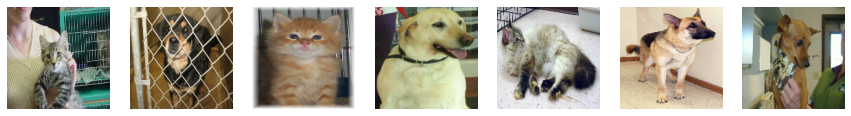

In [10]:
classNames = ['cat', 'dog']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(15,15))
 
for image,label, label2 in train_ds.take(7):
 #  print(image.shape)
 #   predictedLabel = int(predictions[i] >= 0.5)
   # print(label)
   ax[i].axis('off')
  # ax[i].set_title(classNames[label.numpy()])
   ax[i].imshow(image)
    
   i += 1
 
# plt.show()

In [11]:
# shuffle and create batches before training
batch_size = 128
train_batches = train_ds.shuffle(1024).batch(batch_size)
val_batches  = val_ds.shuffle(1024).batch(batch_size)
test_batches =  Test_data.shuffle(1024).batch(batch_size)

In [12]:
image_count_test = tf.data.experimental.cardinality(test_batches).numpy()
image_count_test

37

**Build the GOLD STANDARD classifier**


This will look familiar to you because it is almost identical to the previous model we built. The key difference is the output is just one unit that is sigmoid activated. This is because we're only dealing with two classes.

In [13]:
def build_base_model():
    # base_model = Sequential()


    # base_model.add( Conv2D(32, (3, 3), activation='relu',
    # input_shape=(150, 150, 3)))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add( Dropout(0.2))

    # base_model.add( Conv2D(64, (3, 3), activation='relu'))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add( Dropout(0.2))

    # base_model.add( Conv2D(128, (3, 3), activation='relu'))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add(Dropout(0.2))

    # base_model.add(Conv2D(256, (3, 3), activation='relu'))
    # base_model.add(MaxPooling2D((2, 2)))
    # base_model.add(Dropout(0.2))

    # base_model.add(Flatten())


    # base_model.add(Dense(256, activation='relu'))
    # base_model.add(Dense(1, activation='sigmoid'))

    initializer = tf.keras.initializers.GlorotNormal(seed=100)
    base_model = Sequential()
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3),bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3),bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(128, bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.2))
    base_model.add(Dense(N_CLASSES, bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [14]:
N_CLASSES = 2
def one_hot(image, ytrue, label):
    one_hot_targets = label  # tf.one_hot(tf.cast(label, tf.int32), N_CLASSES, axis = 1, dtype=tf.int32)
    return image, one_hot_targets

In [15]:
train_batches_MV = train_batches.map(one_hot)

In [16]:
val_batches_MV = val_batches.map(one_hot)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
callback1 = tf.keras.callbacks.TerminateOnNaN()
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
#callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                         patience=15, verbose=0, mode="auto",
                                         baseline=None, restore_best_weights=True)

Epoch 1/100


2023-02-14 11:50:36.635488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 [==============================] - 90s 668ms/step - loss: 0.8729 - accuracy: 0.5219 - val_loss: 0.7042 - val_accuracy: 0.5107
Epoch 2/100
110/110 [==============================] - 10s 85ms/step - loss: 0.7283 - accuracy: 0.5409 - val_loss: 0.7052 - val_accuracy: 0.5082
Epoch 3/100
110/110 [==============================] - 11s 93ms/step - loss: 0.7036 - accuracy: 0.5589 - val_loss: 0.7080 - val_accuracy: 0.4970
Epoch 4/100
110/110 [==============================] - 11s 93ms/step - loss: 0.6787 - accuracy: 0.5850 - val_loss: 0.6949 - val_accuracy: 0.5297
Epoch 5/100
110/110 [==============================] - 10s 84ms/step - loss: 0.6596 - accuracy: 0.6016 - val_loss: 0.7059 - val_accuracy: 0.5247
Epoch 6/100
110/110 [==============================] - 11s 94ms/step - loss: 0.6392 - accuracy: 0.6302 - val_loss: 0.7043 - val_accuracy: 0.5402
Epoch 7/100
110/110 [==============================] - 11s 87ms/step - loss: 0.6150 - accuracy: 0.6563 - val_loss: 0.7237 - val_accuracy: 0.5

2023-02-14 12:17:15.009292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 511 of 1024
2023-02-14 12:17:16.084319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 [==============================] - 23s 86ms/step - loss: 0.8692 - accuracy: 0.5273 - val_loss: 0.6956 - val_accuracy: 0.4957
Epoch 2/100
110/110 [==============================] - 10s 80ms/step - loss: 0.7304 - accuracy: 0.5378 - val_loss: 0.7408 - val_accuracy: 0.5090
Epoch 3/100
110/110 [==============================] - 11s 87ms/step - loss: 0.7016 - accuracy: 0.5638 - val_loss: 0.7200 - val_accuracy: 0.5092
Epoch 4/100
110/110 [==============================] - 11s 94ms/step - loss: 0.6835 - accuracy: 0.5768 - val_loss: 0.7164 - val_accuracy: 0.5282
Epoch 5/100
110/110 [==============================] - 10s 84ms/step - loss: 0.6651 - accuracy: 0.6059 - val_loss: 0.6929 - val_accuracy: 0.5423
Epoch 6/100
110/110 [==============================] - 10s 86ms/step - loss: 0.6479 - accuracy: 0.6193 - val_loss: 0.7111 - val_accuracy: 0.5372
Epoch 7/100
110/110 [==============================] - 10s 86ms/step - loss: 0.6273 - accuracy: 0.6457 - val_loss: 0.7016 - val_accuracy: 0.55

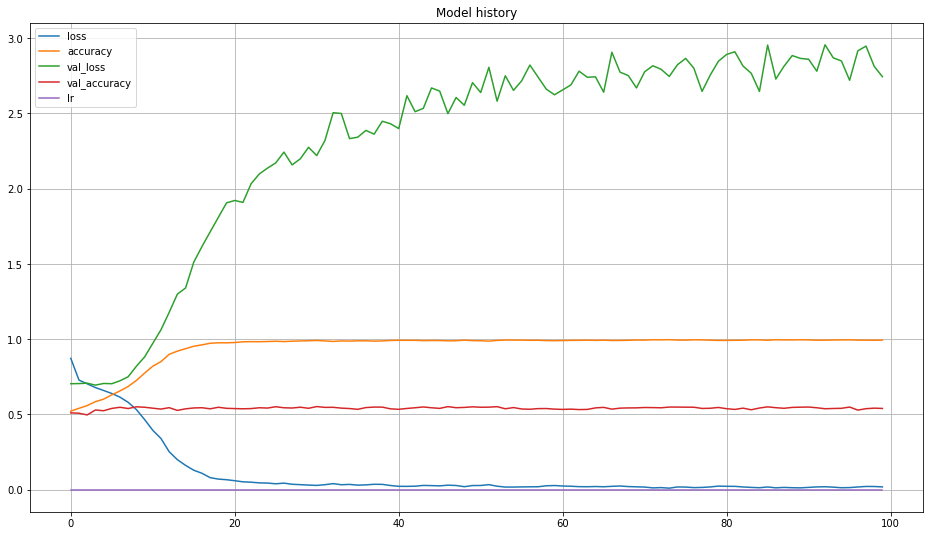

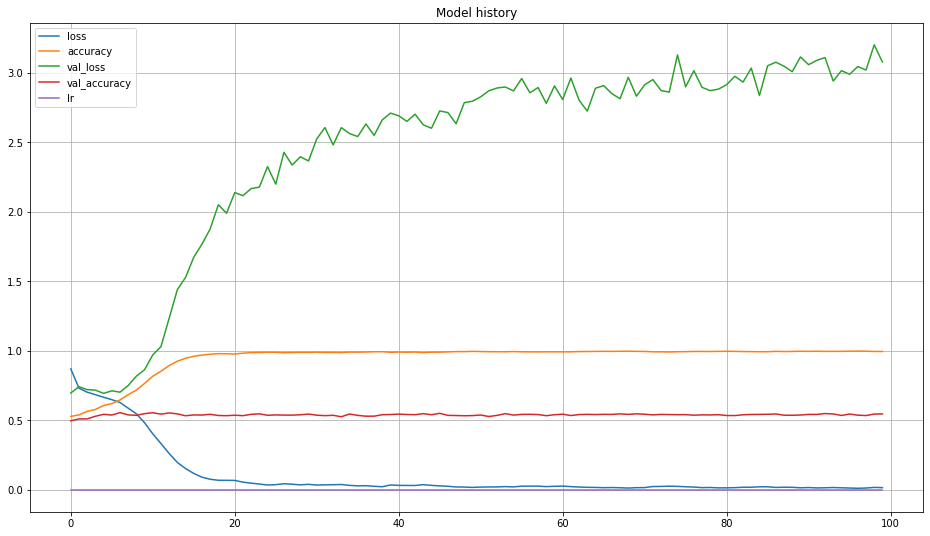

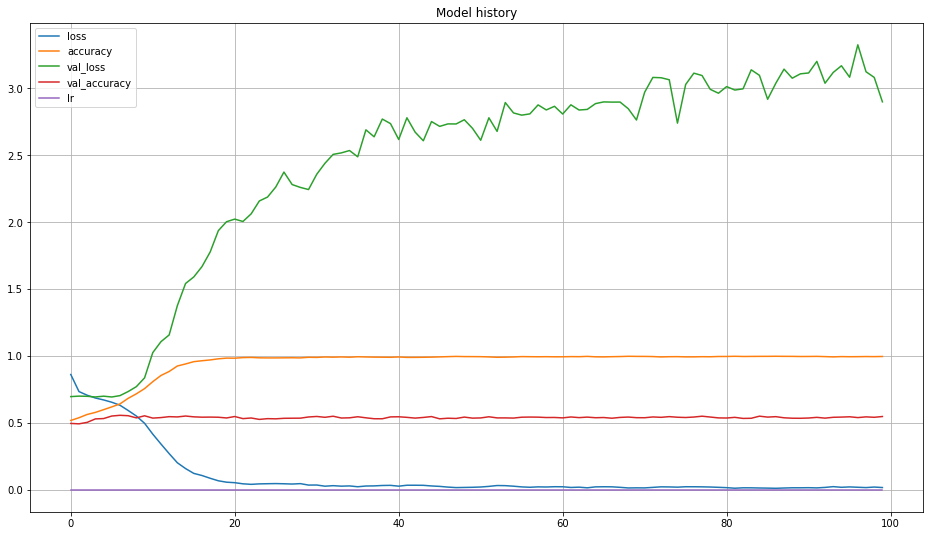

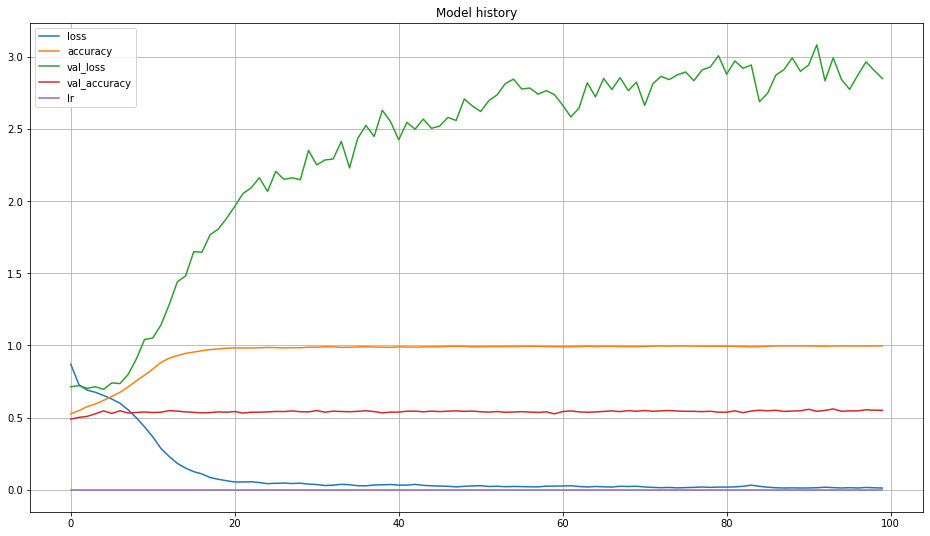

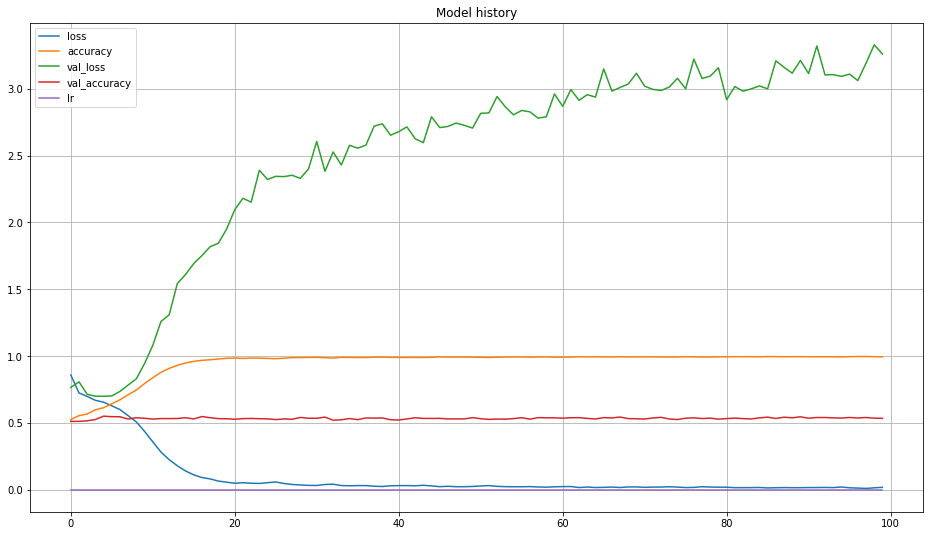

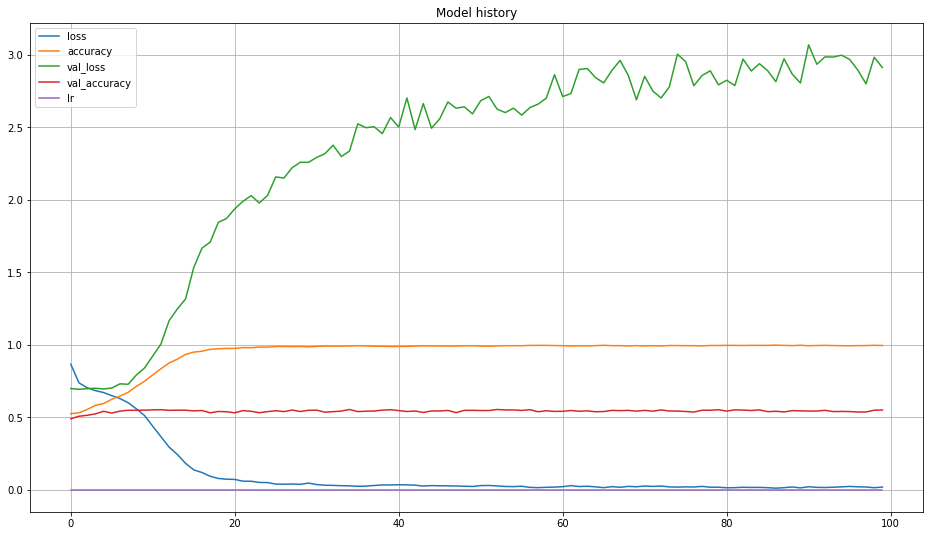

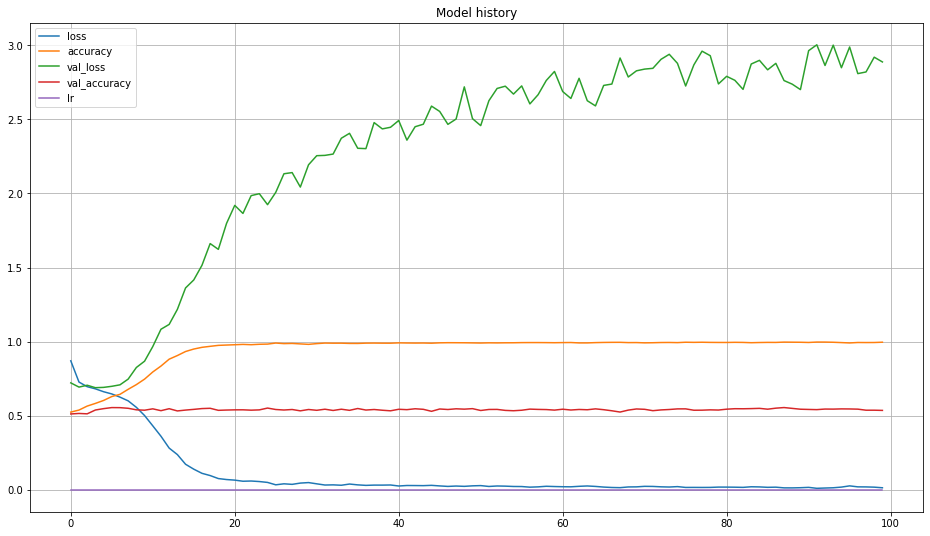

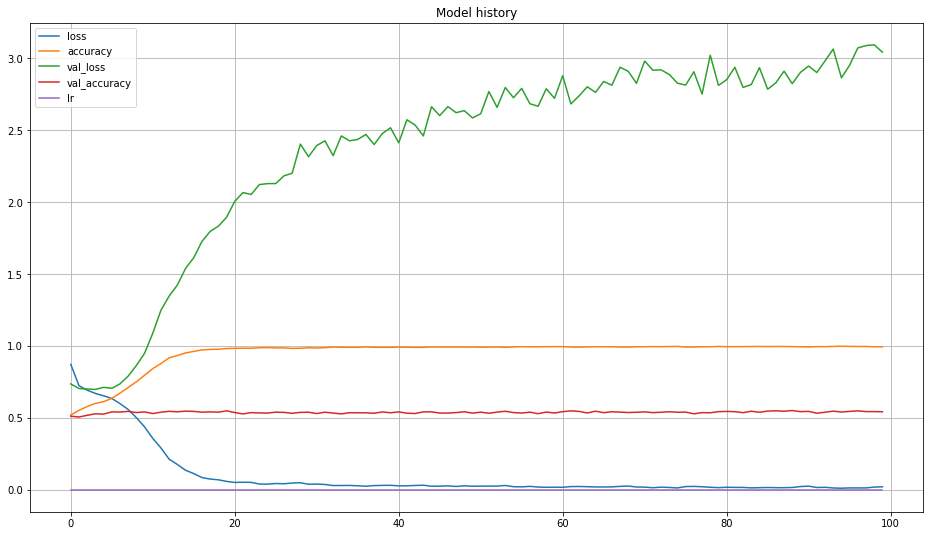

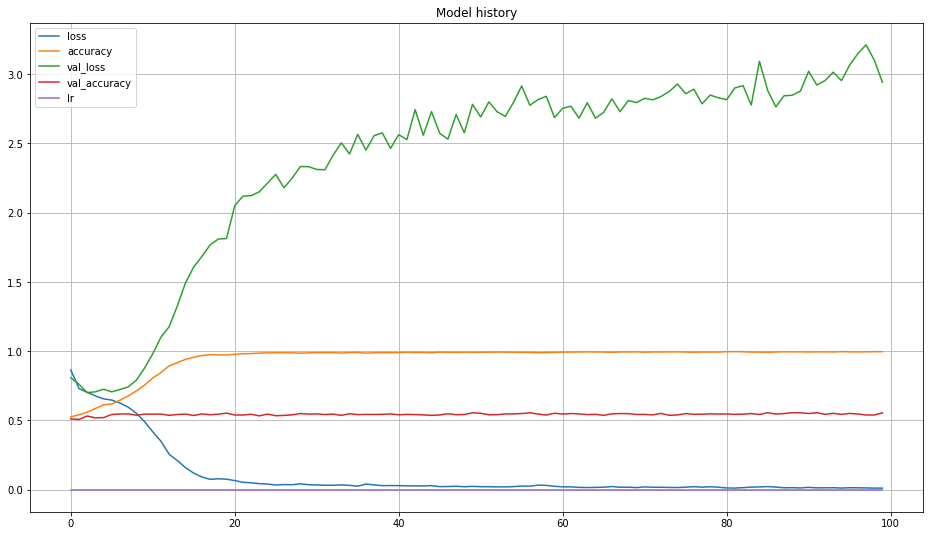

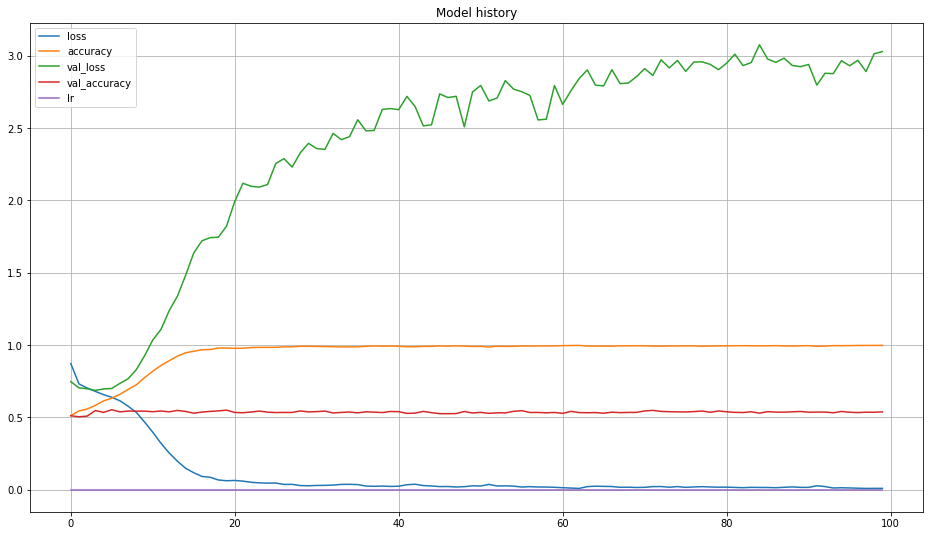

In [19]:
K=2
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
#l1 =0.0001
NUM_RUNS = 10
N_EPOCHS = 100
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
AUCSK = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
AUCSK1 = []
val_acc_goldst = np.zeros(NUM_RUNS)
AUC= np.zeros(NUM_RUNS)
for i in range(NUM_RUNS):
    model = build_base_model()  
    trainHistory = model.fit(train_batches_MV, validation_data= val_batches_MV, epochs=N_EPOCHS,   callbacks = [callback1, callback2])
    (loss, accuracy) = model.evaluate(test_batches)
    #Accurarcy =================
    ACC[i] = accuracy
    print("Validation acc: %.4f" % (float(ACC[i]),))
 
    #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val.numpy(), training=False)
       # tf.print(y_batch_val)
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))   #val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))
        val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))
        BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True))
        MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        AUCSK1.append(roc_auc_score(ook(y_batch_val.numpy()), val_logits[:,:K].numpy().astype('float')))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    #===================================================
    # balanced. Accurcy
    BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))
    AUCSK[i] = np.array(AUCSK1).mean() 
    print("Validation AUCSK: %.4f" % (float( AUCSK[i] )))

    #MI

    MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

    
    
    # Create the history figure
    plt.figure(figsize=(16,9))
    for i in trainHistory.history:
        plt.plot(trainHistory.history[i],label=i)
    plt.title('Model history')
    plt.legend()
    plt.grid()
import pandas as pd

df_gold = pd.DataFrame(val_acc_goldst)
df_gold.to_csv('/kaggle/working/CatDogs_MA_VGG19_GOLD.csv',index=False) # save to notebook output
  

# plt.plot(trainHistory.history['accuracy'])
# plt.plot(trainHistory.history['val_accuracy'])
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Training', 'Validation'])
# plt.grid()
# plt.show()

In [20]:
ACC

array([0.60511607, 0.59909719, 0.60404128, 0.60232157, 0.58469474,
       0.61156493, 0.60468614, 0.60038692, 0.60963029, 0.605546  ])

In [21]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUCSK: ', np.round( AUCSK.mean(),4)*100) 
print('Average AUCSK std: ',np.round(np.std( AUCSK),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  60.27
Average std:  0.7000000000000001
Average AUC:  60.29
Average AUC std:  0.7100000000000001
Average std:  0.7000000000000001
Average AUCSK:  64.1
Average AUCSK std:  0.22999999999999998
Average Balanced Accuracy:  20.44
Average std:  0.33
Average MI:  2.4899999999999998
Average std:  0.06
Average Normalized MI:  3.62
Average std:  0.09
Average Ajdusted MI:  3.62
Average std:  0.09


In [22]:
print('Average Accuracy: ', np.round(val_acc_goldst.mean(),4)*100) 
print('STD Accuracy: ', np.round(np.std(val_acc_goldst),4)*100) 

Average Accuracy:  0.0
STD Accuracy:  0.0


In [23]:
AUC

array([0.60534006, 0.59897858, 0.60440516, 0.60232759, 0.58466834,
       0.61213171, 0.6047824 , 0.60047299, 0.60982627, 0.60599136])

In [24]:
print('Average AUC: ', np.round(AUC.mean(),4)*100) 
print('STD AUC: ', np.round(np.std(AUC),4)*100) 

Average AUC:  60.29
STD AUC:  0.7100000000000001


In [25]:
np.round(np.mean(AUC),4)*100

60.29

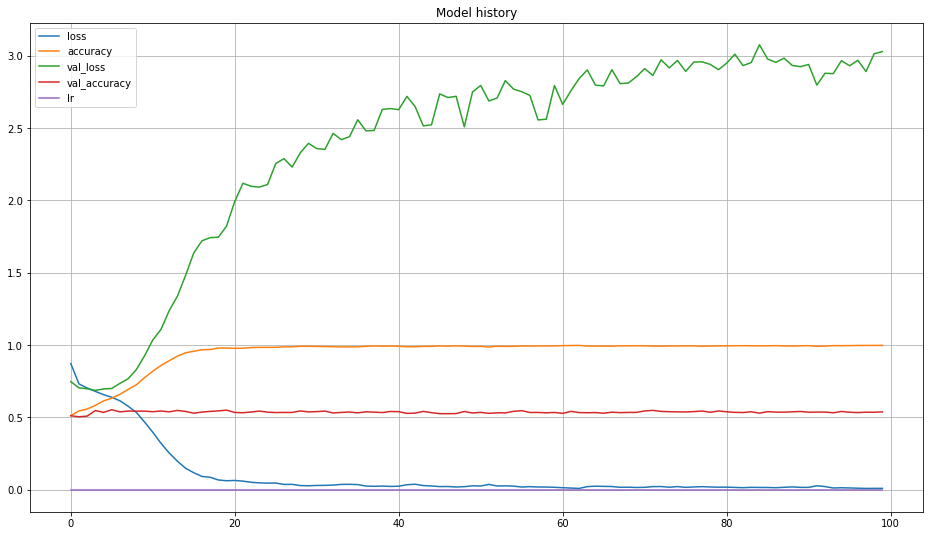

In [26]:
    # Create the history figure
    plt.figure(figsize=(16,9))
    for i in trainHistory.history:
        plt.plot(trainHistory.history[i],label=i)
    plt.title('Model history')
    plt.legend()
    plt.grid()

In [27]:
val_acc_goldst.mean()

0.0

In [28]:
AUC

array([0.60534006, 0.59897858, 0.60440516, 0.60232759, 0.58466834,
       0.61213171, 0.6047824 , 0.60047299, 0.60982627, 0.60599136])

In [29]:
print('Average Accuracy: ', np.round( val_acc_goldst.mean(),4)*100) 
print('Average std: ',np.round(np.std( val_acc_goldst),4)*100)

Average Accuracy:  0.0
Average std:  0.0


In [30]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  60.29
Average std:  0.7100000000000001
